In [2]:
from __future__ import print_function
import cv2 as cv
import argparse
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
def pre_process(dir, file_name, folder="", method="KNN", filter_color=False):
    """Process each individual frame of a video, generating a high contrast set of frames.
    It removes the background and light reflections on the surface of the fluid, with an optional feature of removing the color.
    It's configured to filter all non-blue color by default. To remove another, modify the lower_color and upper_color variables.
    
    Attributes
    ----------
    dir, file_name : str
        directory and file-name for the video you'd like to process. 
    folder (optional) : str
        name of the folder in wich the images will be saved, on the same location as the video.
    method : str
        method used for the background subtraction. Either MOG2 of KNN. Default: KNN
    filter_color : boolian
        whether to apply a color filter on top of the background subtraction. Default: False. 
        NOTE: In order for the color filter to work, you have to adjust the color parameters (lower_color, upper_color)."""
    
    ### Choosing method selected for the background substractor object
    if method == "MOG2":
        backSub = cv.createBackgroundSubtractorMOG2(detectShadows=False)
    if method == "KNN":
        backSub = cv.createBackgroundSubtractorKNN(detectShadows=False)
    else:
        raise(Exception("Invalid method name"))
    
    capture = cv.VideoCapture(cv.samples.findFileOrKeep(dir+"/"+file_name))

    i = 0 ### Initialazing iterable variable
     
    Masks = [] ### Initialazing mask list for saving each mask (i.e. Image matrix comprised of 0s and 255s, black and white.)
    if not capture.isOpened():
        raise(Exception("Unable to open file"))
    while True:
        ret, frame = capture.read() ### Reads each frame of the video
        if frame is None:
            break
        
        fgMask = backSub.apply(frame) ### Substract background
        
        cv.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
        cv.putText(frame, str(capture.get(cv.CAP_PROP_POS_FRAMES)), (15, 15),
        cv.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
        


        res1 = cv.bitwise_and(frame, frame, mask=fgMask)

        gray = cv.cvtColor(res1, cv.COLOR_BGR2GRAY)

        # threshold grayscale image to extract glare
        mask = cv.threshold(gray, 220, 255, cv.THRESH_BINARY)[1]
        res2 = cv.inpaint(res1, mask, 21, cv.INPAINT_TELEA) 

        if filter_color:

            ### convert the BGR image to HSV colour space
            hsv = cv.cvtColor(res2, cv.COLOR_BGR2HSV)

            ### set the lower and upper bounds for the color hue
            lower_color = np.array([60, 35, 140])
            upper_color = np.array([180, 255, 255])
 
            ### create a mask for color colour using inRange function
            mask = cv.inRange(hsv, lower_color, upper_color)

            ### perform bitwise and on the original image arrays using the mask
            res3 = cv.bitwise_and(res2, res2, mask=mask)
            
            ### display original frame, and filtered black and white frame. 
            cv.imshow('Frame', frame)
            cv.imshow('FG Mask', mask)

            if i < 10:
                imagen_numero = f"000{i}.jpg"
            elif 100 > i >= 10:
                imagen_numero = f"00{i}.jpg"
            elif 1000 > i >= 100:
                imagen_numero = f"0{i}.jpg"
            else:
                imagen_numero = f"{i}.jpg"

            ### Save file
            cv.imwrite(dir+folder+"/"+imagen_numero,res3)
            i += 1

        else:
            ### display original frame, and filtered frame. 
            cv.imshow('Frame', frame)
            cv.imshow('FG Mask', res2)

            if i < 10:
                imagen_numero = f"000{i}.jpg"
            elif 100 > i >= 10:
                imagen_numero = f"00{i}.jpg"
            elif 1000 > i >= 100:
                imagen_numero = f"0{i}.jpg"
            else:
                imagen_numero = f"{i}.jpg"
            
            ### Save file
            cv.imwrite(dir+"/"+folder+"/"+imagen_numero,res2)
            i += 1
        
        Masks.append(mask) ### Add mask to mask list
        keyboard = cv.waitKey(30)
        if keyboard == 'q' or keyboard == 27:
            break
        
        ### Display progress
        if i%20 == 0:
            print(i, end="\r")
    
    ### Close all windows

    capture.release()
    # video.release()
    cv.destroyAllWindows()
    cv.waitKey(1)
    return Masks

### Particular example

In [104]:
dir = "/glicerina 50 glitter"
folder = "glicerina 50 oscura dos filtros"
file_name = "glicerina oscura.mov"
method = "KNN"

Masks = pre_process(dir=dir, file_name=file_name, folder=folder, method=method, filter_color=False)

### Pruebo el código de OpenPIV a ver si funciona

In [5]:
from openpiv import tools, pyprocess, validation, filters, scaling, smoothn

import imageio
from os import remove
from tqdm import tqdm as tdqm
import seaborn as sns

In [181]:
def get_velocity_field(start, stop, path, fps, step=1, winsize=32, searchsize=32, 
                       overlap=16, threshold=2, remove_outliers=False):
    '''
    Attributes
    ----------
    start // stop // step: int
        defines the frame in wich to start // end the field calculation, and the step between each frame (defaults to 1).
    fps : int
        frames per second of the video from wich the images were extracted.
    winsize : int
        pixels, interrogation window size in frame A
    searchsize : int
        pixels, search in image B. Cannot be smaller than winsize!
    threshold : int
        threshold for the sig2noice validation. The validation then eliminates the vector for wich the sig2noice value surpasses the threshold.
    overlap : int:
        pixels, overlap between two windows (defines point density)
    
    '''
    
    U, V = [], []

    for frame_idx in tdqm(range(start, stop, step)):
        if frame_idx < 10:
            imagen_numero_1 = f"000{frame_idx}.jpg"
        elif 100 > frame_idx >= 10:
            imagen_numero_1 = f"00{frame_idx}.jpg"
        elif 1000 > frame_idx >= 100:
            imagen_numero_1 = f"0{frame_idx}.jpg"
        else:
            imagen_numero_1 = f"{frame_idx}.jpg"
        
        frame_idx_2 = frame_idx + 1
        
        if frame_idx_2 < 10:
            imagen_numero_2 = f"000{frame_idx_2}.jpg"
        elif 100 > frame_idx_2 >= 10:
            imagen_numero_2 = f"00{frame_idx_2}.jpg"
        elif 1000 > frame_idx_2 >= 100:
            imagen_numero_2 = f"0{frame_idx_2}.jpg"
        else:
            imagen_numero_2 = f"{frame_idx_2}.jpg"
        
        try:
            frame_a  = tools.imread(path+imagen_numero_1)
            frame_b  = tools.imread(path+imagen_numero_2)
        except:
            raise(Exception("frame index out of range; Check: \n that the stop argument is lower than the total number of frames or \n \t that the name format for the image is the right one."))

        

        dt = 1/fps # sec, time interval between frames

        u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                            frame_b.astype(np.int32), 
                                                            window_size=winsize, 
                                                            overlap=overlap, 
                                                            dt=dt, 
                                                            search_area_size=searchsize, 
                                                            sig2noise_method='peak2peak')

        x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                        search_area_size=searchsize, 
                                        overlap=overlap )
        
        u1, v1 = u0.copy(), v0.copy()

        u1, v1, mask = validation.sig2noise_val( u1, v1, 
                                                sig2noise, 
                                                threshold = threshold)


            
  

        # to see where is a reasonable limit

        # filter out outliers that are very different from the
        # neighbours
        if remove_outliers:
            u2, v2 = filters.replace_outliers( u1, v1, 
                                            method='localmean', 
                                            max_iter=3, 
                                            kernel_size=3)

        else:
            u2, v2 = u1, v1

        ### convert x,y to mm
        ### convert u,v to mm/sec

        x3, y3, u3, v3 = scaling.uniform(x, y, u2, v2, 
                                    scaling_factor = 1096.52 ) # 96.52 microns/pixel

        ### 0,0 shall be bottom left, positive rotation rate is counterclockwise
        ### Note: Imread reads each frame inverted on the y-axis (dunno why),
        ### so we have to adjust for that reflection (View plots)
        x3, y3, u3, v3 = tools.transform_coordinates(x3, y3, u3, v3)

        ### Display frame #5 & #10 and their raw fields just to show its working correctly:
        if frame_idx in [5, 15]:
            fig, axs = plt.subplots(2, 2,figsize=(20, 20))
            axs[0,0].quiver(x, y, u0, v0, 
                    #   np.sqrt(u0**2 + v0**2), ### show intensity of the field with a colour range
                      lw=.2)
            axs[0,0].imshow(frame_a, cmap="Greens", origin="lower")
            axs[0,0].set_title("Calculated Velocity Field")
            # plt.show()
            axs[0,1].quiver(x, y, u1, v1, 
                    #   np.sqrt(u1**2 + v1**2), ### show intensity of the field with a colour range
                      lw=.2)
            axs[0,1].imshow(frame_a, cmap="Greens", origin="lower")
            axs[0,1].set_title("Filtered Velocity Field")
            # plt.show()
            axs[1,0].quiver(x, y, u2, v2, 
                    #   np.sqrt(u2**2 + v2**2), ### show intensity of the field with a colour range
                      lw=.2)
            axs[1,0].set_title("Smoothened Velocity Field")
            # plt.show()
            axs[1,1].quiver(x3, y3, u3, v3, 
                      np.sqrt(u3**2 + v3**2), ### show intensity of the field with a colour range
                      lw=.2)
            axs[1,1].set_title("Adjusted Velocity Field")
            plt.show()
            
            ### if you need more detailed look, first create a histogram of sig2noise
            fig, axs = plt.subplots(1, 2,figsize=(20, 8))
            axs[0].hist([s2n if (s2n != 0.0) and (s2n < 1e2) else np.nan for s2n in sig2noise.flatten()], bins=100)
            axs[0].set_xlim(0, 10)
            axs[0].set_xticks(np.arange(1, 10, .5), rotation=90)
            axs[0].grid()
            axs[0].set_title("Histogram of the sig2noice of all the velocity vectors \n(the higher sig2noice, the better)")

            s2n_filtered = [s2n if (s2n != 0.) and (s2n < 10) else np.nan for s2n in sig2noise.flatten()]
            s2n_matrix = np.array(s2n_filtered).reshape(u1.shape)
            sns.heatmap(s2n_matrix, linewidth=0.5, ax=axs[1])
            axs[1].imshow(frame_a)
            axs[1].set_title("Heat map for signal to noice ratio \n(the higher sig2noice, the better)")
            plt.show()

        U.append(u3)
        V.append(v3)
    return x3, y3, U, V

  2%|▎         | 1/40 [00:00<00:20,  1.95it/s]

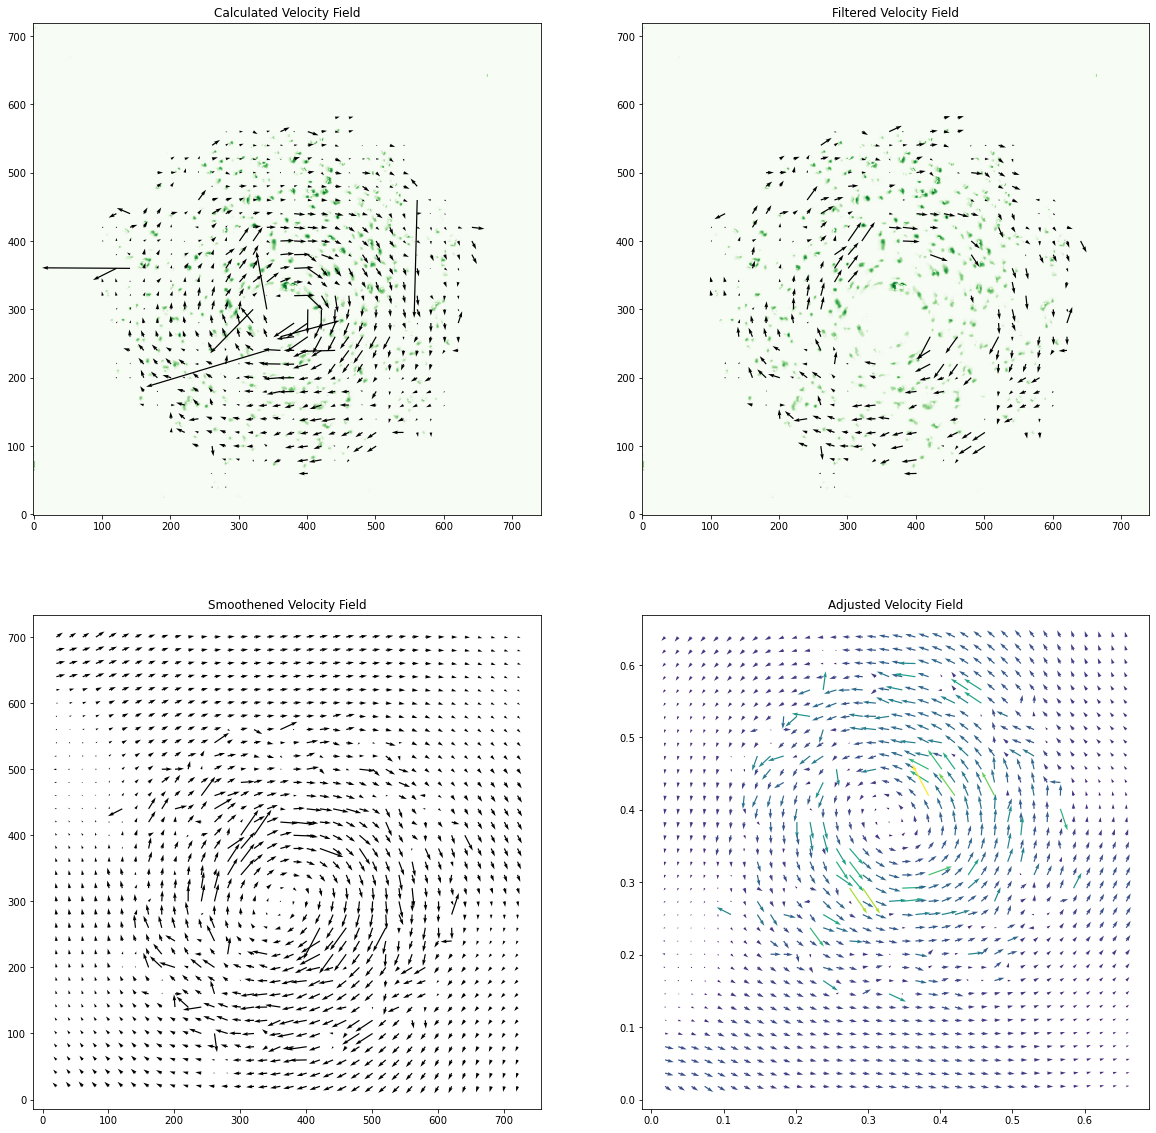

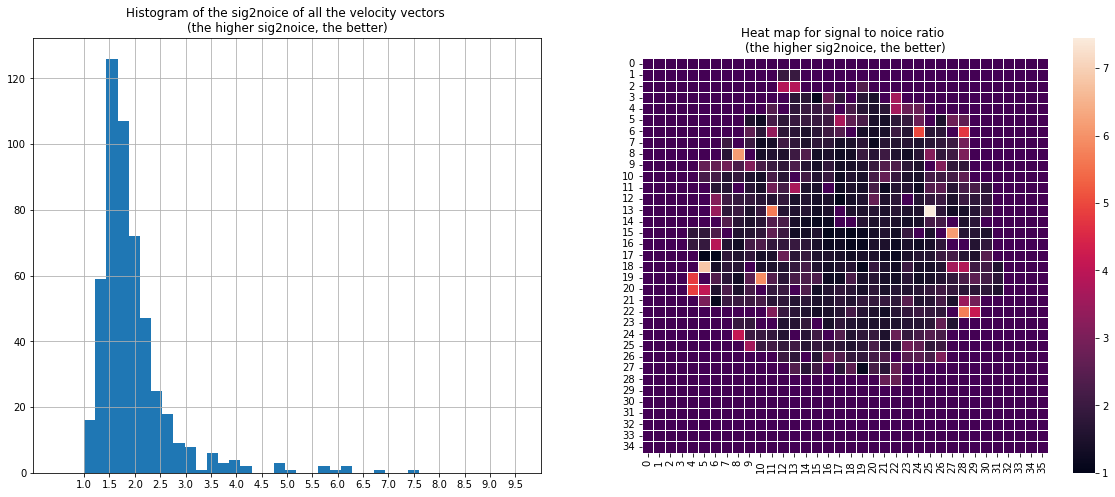

 28%|██▊       | 11/40 [00:06<00:13,  2.13it/s]

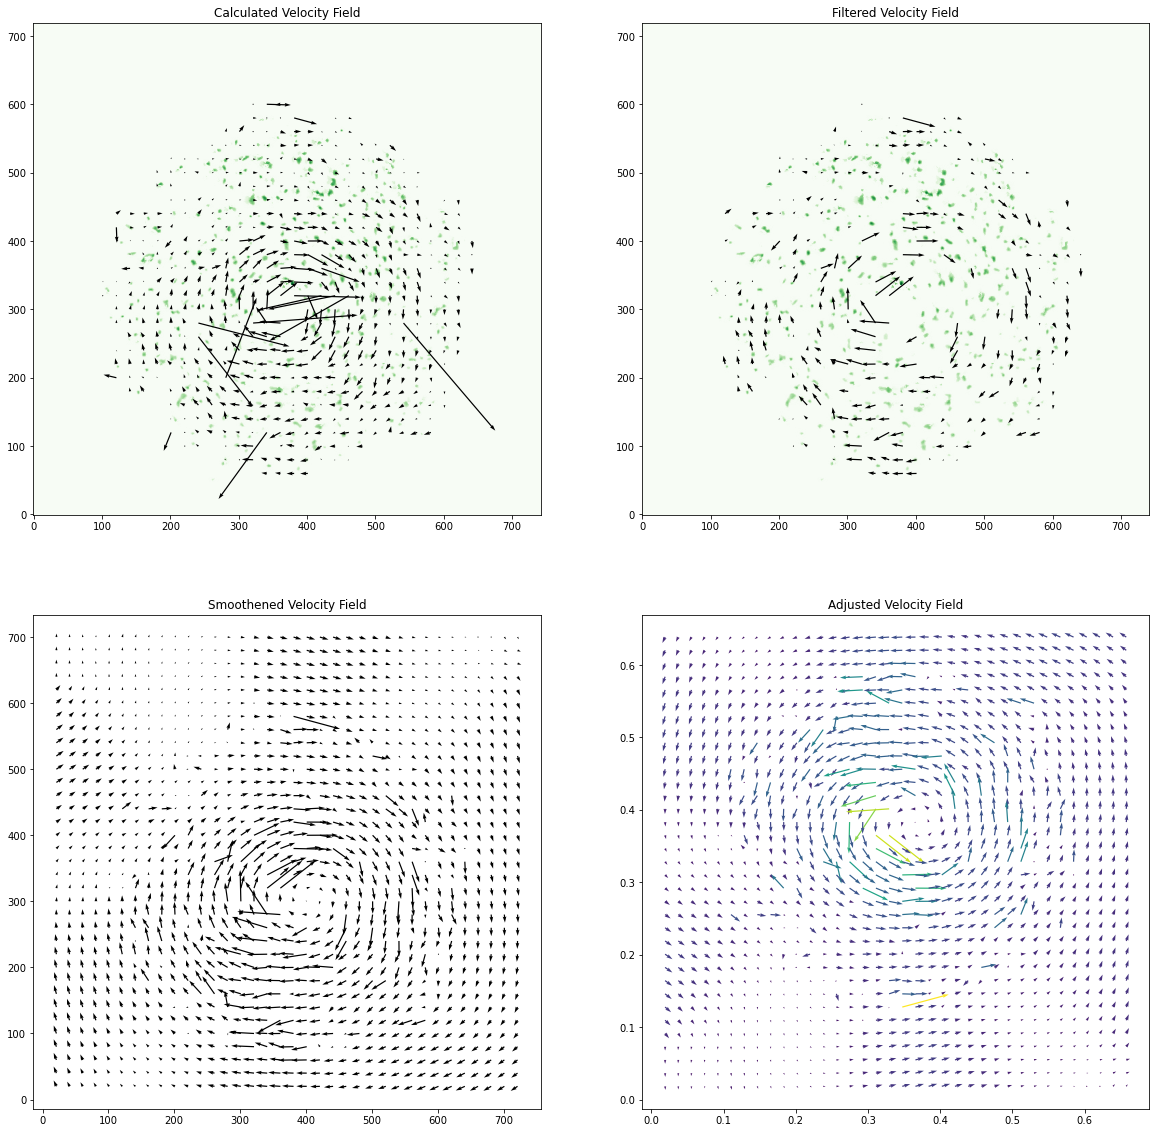

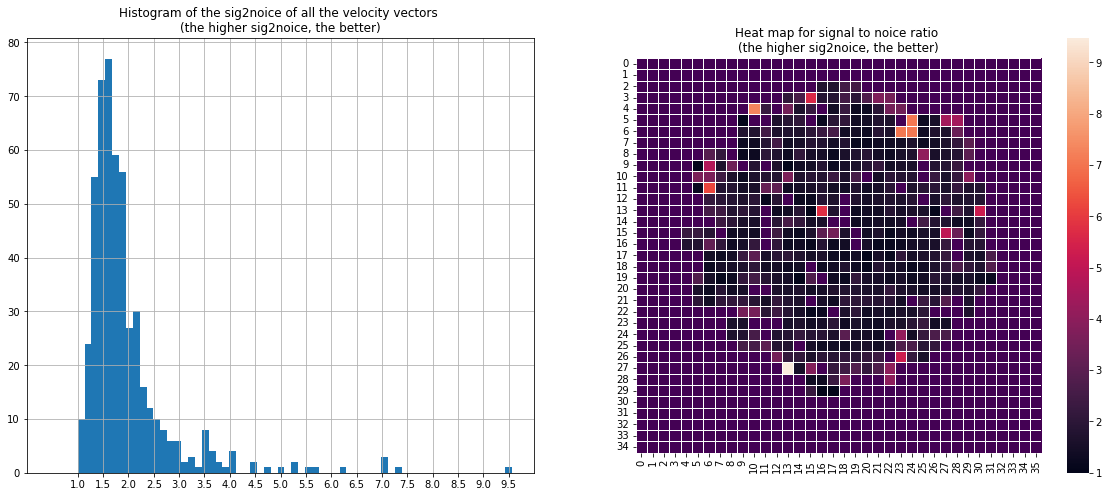

100%|██████████| 40/40 [00:20<00:00,  1.96it/s]


In [182]:
path = "/Users/eitu/Documents/Facu/Labo5/VortexVField/destilada con colorante glitter/destilada oscura dos filtros/"
fps = 240
ws = 32
ss = 32
ol = 12
threshold = 1.7 ### After a few iterations with different thresholds, this is the one we landed on.
x, y, U, V = get_velocity_field(4, 44, path, fps, winsize=ws, searchsize=ss, overlap=ol, threshold=threshold, remove_outliers=True)

In [107]:
U_total = np.zeros_like(U[0])
for i in tdqm(range(U[0].shape[0])):
    for j in range(U[0].shape[1]):
        U_total[i, j] = 0
        counter = 0
        for k in range(len(U)):
            if ~np.isnan(U[k][i, j]):
                U_total[i, j] += U[k][i, j]
                counter += 1
        if counter != 0:
            U_total[i, j] = U_total[i, j]/counter

V_total = np.zeros_like(V[0])
for i in tdqm(range(V[0].shape[0])):
    for j in range(V[0].shape[1]):
        V_total[i, j] = 0
        counter = 0
        for k in range(len(V)):
            if ~np.isnan(U[k][i, j]):
                V_total[i, j] += V[k][i, j]
                counter += 1
        if counter != 0:
            V_total[i, j] = V_total[i, j]/counter

In [108]:
mask = np.zeros(U[0].shape, dtype=bool) ### Define the mask as an all-true matrix, bc we wont take into account the error in calculating the velocities for each frame.

### Remove outliers gloval:

# U_total, V_total = filters.replace_outliers( U_total, V_total, method='localmean', max_iter=3, kernel_size=3)

tools.save(x, y, U_total, V_total, mask, path + 'destilada remove_outliers.txt' )
np.save(path + "U destilada remove_outliers.npy", U)
np.save(path + "V destilada remove_outliers.npy", V)

### Prueba de interpolación

In [114]:
from scipy.interpolate import griddata

In [115]:
### Interpolate Total Field (U_total, V_total), generating a position meshgrid of (n_points x n_points) [x_mesh, y_mesh]
### Generates interpolated vector fields [U_grid, V_grid]

### create matrix of [x, y] points (example: np.array([[0, 10], [1, 10] ... [10, 10]]), [[0, 9], [1, 9] ... [10, 9]] ...)
xy_points = np.concatenate([x.reshape(x.shape[0]*x.shape[1], 1), y.reshape(y.shape[0]*y.shape[1], 1)], axis=1)
U_flattened = U_total.flatten()
V_flattened = V_total.flatten()
n_points = 150
### create high density meshgrid of x,y points
x_mesh, y_mesh = np.meshgrid(np.linspace(np.min(x), np.max(x), n_points), np.linspace(np.min(y), np.max(y), n_points))
U_grid = griddata(xy_points, U_flattened, (x_mesh, y_mesh), method="cubic")
V_grid = griddata(xy_points, V_flattened, (x_mesh, y_mesh), method="cubic")

In [145]:
### Save interpolation
mask_interpolation = np.zeros(U_grid.shape, dtype=bool) ### Have to define a mask for the tools.save to work
tools.save(x_mesh, y_mesh, U_grid, V_grid, mask=mask_interpolation, filename=path + 'destilada remove_outliers interpolacion 150.txt')

### Pruebo distintas visualizaciones

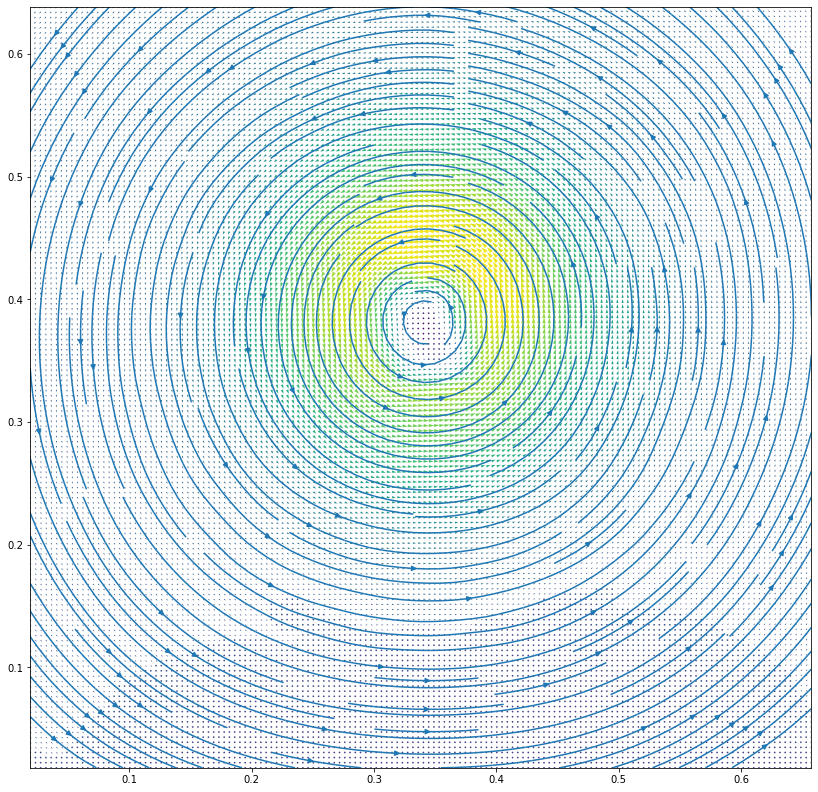

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(14, 14))
ax.quiver(x_mesh, y_mesh, U_grid, V_grid, np.sqrt(U_grid**2 + V_grid**2), lw=.2)
ax.streamplot(x_mesh, y_mesh, U_grid, V_grid, density=2)

### Analizo diferencias entre los distintos procesamientos

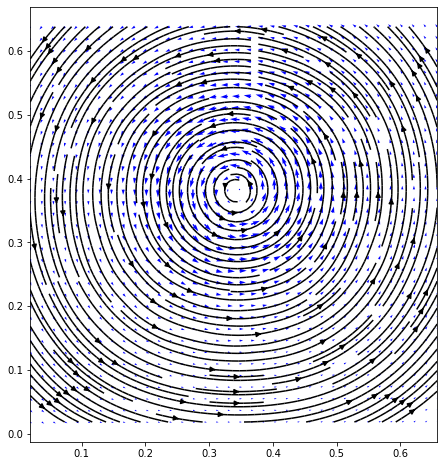

In [143]:
fig, ax = plt.subplots(figsize=(8,8))
# ax.quiver(x_mesh, y_mesh, U_grid, V_grid, np.sqrt(U_grid**2 + V_grid**2), lw=.2)
ax.streamplot(x_mesh, y_mesh, U_grid, V_grid, density=2, color="black")
tools.display_vector_field(path + 'destilada remove_outliers.txt',
                           ax=ax, scaling_factor=96.52, scale=10,# scale defines here the arrow length
                           width=0.0035, # width is the thickness of the arrow
                           on_img=False, # overlay on the image
                           # image_name='__file directory for the image__'
                        )
ax.set_title("destilada con remove outliers (32, 32, 12, 1.7)")
plt.show()

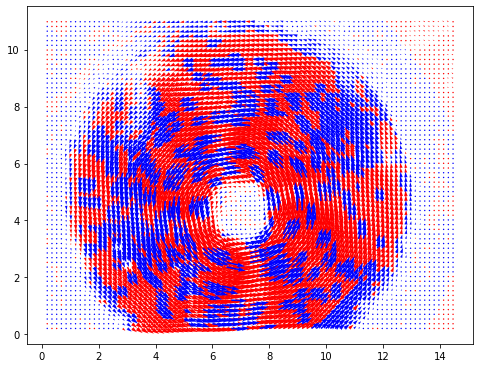

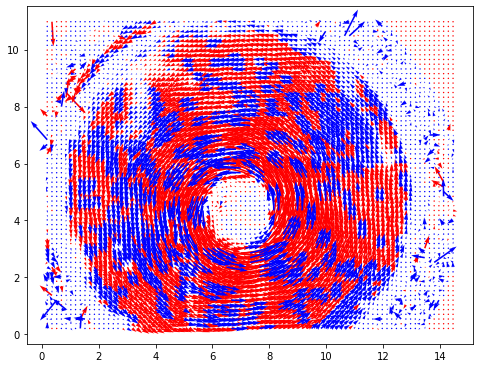

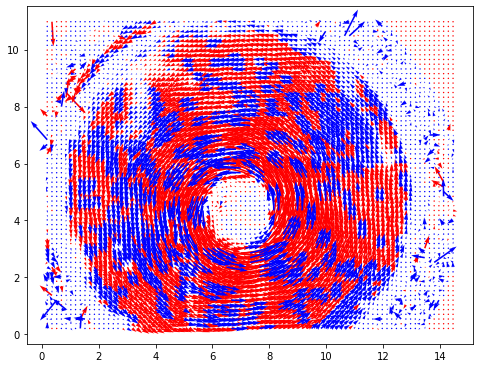

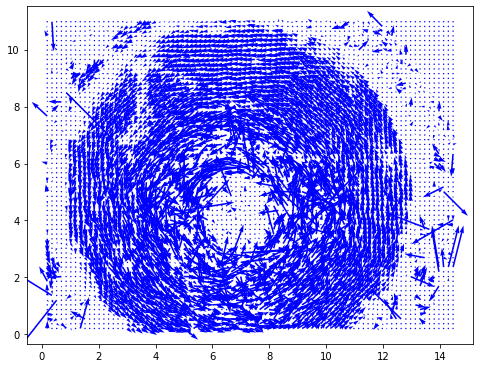

Text(0.5, 1.0, 'prueba con remove_outliers y sig2noise_val global')

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field('Con remove_outliers a cada uv.txt', 
                           ax=ax, scaling_factor=96.52, 
                           scale=80, # scale defines here the arrow length
                           width=0.0035, # width is the thickness of the arrow
                           on_img=False # overlay on the image
                        #    image_name='Imagenes recuperadas/0.png'
                        );
ax.set_title("Con remove_outliers a cada u, v")


fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field('Con remove_outliers global.txt', 
                           ax=ax, scaling_factor=96.52, 
                           scale=80, # scale defines here the arrow length
                           width=0.0035, # width is the thickness of the arrow
                           on_img=False # overlay on the image
                        #    image_name='Imagenes recuperadas/0.png'
                        );
ax.set_title("Con remove_outliers global")

fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field('Sin remove_outliers.txt', 
                           ax=ax, scaling_factor=96.52, 
                           scale=80, # scale defines here the arrow length
                           width=0.0035, # width is the thickness of the arrow
                           on_img=False # overlay on the image
                        #    image_name='Imagenes recuperadas/0.png'
                        );
ax.set_title("Sin remove_outliers")

fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field('treshhold2.txt', 
                           ax=ax, scaling_factor=96.52, 
                           scale=80, # scale defines here the arrow length
                           width=0.0035, # width is the thickness of the arrow
                           on_img=False # overlay on the image
                        #    image_name='Imagenes recuperadas/0.png'
                        );
ax.set_title("prueba cambiandole el threshhold a 2")